# 26. OpenAI Whisper를 활용한 영상 요약

## 프로젝트 개요

이 노트북은 영상 파일에서 음성을 추출하고, OpenAI Whisper를 사용하여 텍스트로 변환한 후, 내용을 요약하여 Notion 데이터베이스에 자동으로 업로드하는 시스템을 구축합니다.

### 주요 기능
1. **영상 파일 처리**: 음성 추출 및 텍스트 변환
2. **자동 요약**: AI를 활용한 영상 내용 요약 및 아웃라인 생성  
3. **Notion 연동**: 처리된 내용을 자동으로 Notion 데이터베이스에 저장

### 사용 기술
- OpenAI Whisper: 음성-텍스트 변환
- LangGraph: 워크플로우 관리
- OpenAI GPT: 텍스트 요약
- Notion API: 데이터 저장



## 1. 환경 설정


In [1]:
# 환경 변수 로드 - OpenAI API 키와 Notion API 키를 .env 파일에서 불러옵니다
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv()

True

## 2. 워크플로우 상태 정의

LangGraph에서 사용할 상태 구조를 정의합니다. 이 상태는 전체 워크플로우에서 데이터가 어떻게 흘러가는지 관리합니다.


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

# 워크플로우에서 사용할 상태 구조 정의
class AgentState(TypedDict):
    file_path: str      # 처리할 영상 파일 경로
    transcript: str     # Whisper로 추출한 텍스트
    outline: str        # 생성된 아웃라인
    title: str          # 영상/문서 제목
    database_id: str    # Notion 데이터베이스 ID
    
# 상태 그래프 빌더 초기화
graph_builder = StateGraph(AgentState)

## 3. AI 모델 초기화

OpenAI의 ChatGPT와 Whisper 모델을 초기화합니다. 이 모델들은 각각 텍스트 요약과 음성-텍스트 변환에 사용됩니다.


In [3]:
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

# ChatGPT 모델 초기화 - 텍스트 요약과 아웃라인 생성에 사용
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # temperature=0으로 설정하여 일관된 결과 생성

# Whisper 파서 초기화 - 음성/영상 파일에서 텍스트 추출에 사용
audio_parser = OpenAIWhisperParser()

## 4. 워크플로우 노드 함수 정의

### 4.1 트랜스크립트 추출 함수

영상 파일에서 OpenAI Whisper를 사용하여 음성을 텍스트로 변환하는 함수입니다.


In [4]:
from langchain_core.documents.base import Blob
from langchain_community.document_loaders.parsers.audio import OpenAIWhisperParser

def extract_transcript(state: AgentState) -> AgentState:
    """
    영상 파일에서 음성을 추출하여 텍스트로 변환하는 함수
    """
    # 상태에서 파일 경로 가져오기
    file_path = state["file_path"]
    
    # 파일을 Blob 객체로 변환 (Whisper가 처리할 수 있는 형태)
    audio_blob = Blob(path=file_path)
    
    # Whisper를 사용하여 음성을 텍스트로 변환
    documents = audio_parser.lazy_parse(audio_blob)
    
    # 변환된 텍스트들을 하나의 문자열로 결합
    transcript = ""
    for doc in documents:
        transcript += doc.page_content
    
    # 결과를 상태로 반환
    return {"transcript": transcript}

### 4.2 아웃라인 생성 함수

추출된 텍스트를 바탕으로 ChatGPT를 사용하여 한국어 아웃라인을 생성하는 함수입니다.


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 아웃라인 생성용 모델 (더 정확한 결과를 위해 gpt-4o 사용)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def generate_outline(state: AgentState) -> AgentState:
    """
    추출된 텍스트를 바탕으로 한국어 아웃라인을 생성하는 함수
    """
    # 상태에서 트랜스크립트 가져오기
    transcript = state["transcript"]
    
    # 아웃라인 생성을 위한 프롬프트 템플릿 설정
    outline_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that generates an outline for a transcript. Make sure to use Korean when you generate the outline."),
        ("user", "Generate an outline for the following transcript: {transcript}"),
    ])
    
    # 체인 구성: 프롬프트 -> LLM -> 문자열 파서
    outline_chain = outline_prompt | llm | StrOutputParser()
    
    # 아웃라인 생성
    outline = outline_chain.invoke({"transcript": transcript})
    
    # 결과를 상태로 반환
    return {"outline": outline}

### 4.3 Notion 업로드 함수

생성된 아웃라인을 Notion 데이터베이스에 새로운 페이지로 업로드하는 함수입니다.


In [6]:
import requests
import os

def upload_to_notion(state: AgentState) -> AgentState:
    """
    생성된 아웃라인을 Notion 데이터베이스에 업로드하는 함수
    """
    # 상태에서 필요한 정보 가져오기
    database_id = state['database_id']  # Notion 데이터베이스 ID
    title = state['title']              # 페이지 제목
    outline = state['outline']          # 생성된 아웃라인
    
    # 환경 변수에서 Notion API 키 가져오기
    notion_api_key = os.getenv("NOTION_API_KEY")
    
    # Notion API 요청 헤더 설정
    headers = {
        'Authorization': f'Bearer {notion_api_key}',
        'Content-Type': 'application/json',
        'Notion-Version': '2022-06-28'  # Notion API 버전 지정
    }
    
    # 새 페이지 생성을 위한 데이터 구성
    data = {
        'parent': {'database_id': database_id},  # 부모 데이터베이스 지정
        'properties': {
            'Title': {'title': [{'text': {'content': title}}]},  # 페이지 제목 설정
        },
        'children': [
            {
                'object': 'block',
                'type': 'paragraph',
                'paragraph': {'rich_text': [{'type': 'text', 'text': {'content': outline}}]},  # 아웃라인 내용 추가
            }
        ]
    }
    
    # Notion API에 페이지 생성 요청
    response = requests.post(
        'https://api.notion.com/v1/pages',
        headers=headers,
        json=data
    )
    
    # 응답 결과 출력
    print(response.json())
    return {}

## 5. 워크플로우 그래프 구성

### 5.1 노드 추가

정의한 함수들을 그래프의 노드로 추가합니다.


In [7]:
# 워크플로우 그래프에 노드 추가
graph_builder.add_node(extract_transcript)  # 트랜스크립트 추출 노드
graph_builder.add_node(generate_outline)    # 아웃라인 생성 노드
graph_builder.add_node(upload_to_notion)    # Notion 업로드 노드

### 5.2 워크플로우 엣지 연결 및 그래프 컴파일

노드들 간의 실행 순서를 정의하고 그래프를 컴파일합니다.


In [8]:
from langgraph.graph import START, END

# 워크플로우 실행 순서 정의 (엣지 연결)
graph_builder.add_edge(START, 'extract_transcript')                   # 시작 → 트랜스크립트 추출
graph_builder.add_edge('extract_transcript', 'generate_outline')      # 트랜스크립트 추출 → 아웃라인 생성
graph_builder.add_edge('generate_outline', 'upload_to_notion')        # 아웃라인 생성 → Notion 업로드
graph_builder.add_edge('upload_to_notion', END)                       # Notion 업로드 → 종료


# 그래프 컴파일 (실행 가능한 상태로 변환)
graph = graph_builder.compile()

## 6. 워크플로우 시각화

구성된 워크플로우를 시각적으로 확인할 수 있습니다.


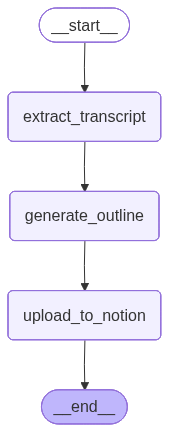

In [9]:
# 워크플로우 그래프 시각화
graph

## 7. 워크플로우 실행

실제 영상 파일을 처리하여 전체 워크플로우를 실행합니다.

### 실행 파라미터
- `file_path`: 처리할 영상 파일 경로
- `database_id`: Notion 데이터베이스 ID
- `title`: 생성될 페이지 제목

### 실행 순서
1. 영상 파일에서 음성 추출 및 텍스트 변환
2. 추출된 텍스트를 바탕으로 한국어 아웃라인 생성
3. 생성된 아웃라인을 Notion 데이터베이스에 업로드


In [10]:
# 워크플로우 실행
# 영상 파일 경로, Notion 데이터베이스 ID, 제목을 설정하여 전체 프로세스 실행
graph.invoke({ 
    "file_path": "./videos/0_2_dimension_measure.mp4",  # 처리할 영상 파일 경로
    "database_id": "2ad02806fca5801e90efe6cf13d24c48",  # Notion 데이터베이스 ID
    "title": "Dimension과 Measure 비교"                      # 페이지 제목
})

Transcribing part 1!
{'object': 'page', 'id': '2ad02806-fca5-8160-8b3e-f04b3d9d2db0', 'created_time': '2025-11-16T13:17:00.000Z', 'last_edited_time': '2025-11-16T13:17:00.000Z', 'created_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'last_edited_by': {'object': 'user', 'id': 'a3e9d8ff-9759-4e80-a48b-a46689b34764'}, 'cover': None, 'icon': None, 'parent': {'type': 'database_id', 'database_id': '2ad02806-fca5-801e-90ef-e6cf13d24c48'}, 'archived': False, 'in_trash': False, 'is_locked': False, 'properties': {'Title': {'id': 'title', 'type': 'title', 'title': [{'type': 'text', 'text': {'content': 'Dimension과 Measure 비교', 'link': None}, 'annotations': {'bold': False, 'italic': False, 'strikethrough': False, 'underline': False, 'code': False, 'color': 'default'}, 'plain_text': 'Dimension과 Measure 비교', 'href': None}]}}, 'url': 'https://www.notion.so/Dimension-Measure-2ad02806fca581608b3ef04b3d9d2db0', 'public_url': None, 'request_id': 'ee9a9582-61d7-49f1-ab13-b1c82fbe33

{'file_path': './videos/0_2_dimension_measure.mp4',
 'transcript': '그럼 태블러 시험범위 중에서 태블러의 기본 개념을 다루는 이 도메인4로 들어가겠습니다. 일단 데이터를 엑셀로 열어서 확인해 봅시다. 이 South Superstore 라는 엑셀은 아래 여러가지 탭들로 이루어져 있네요. 지금 보면 Southern Region 이라는 탭은 맨 왼쪽에 rowid라는 컬럼부터 시작해서 오더 데이트라는 날짜 형식의 컬럼도 보이고 커스텀을 네임이라던지 세그먼트와 같이 문자 형식의 데이터도 보이구요. 여기 세일즈라던지 프로핏같이 숫자 형식의 데이터도 확인할 수 있습니다. 이 데이터를 태블러로 불러올 거에요. 저희의 데이터는 엑셀 파일이기 때문에 이 마이크로소프트 엑셀을 통해서 해당 파일을 열 것입니다. 이렇게 열면 여기 데이터 소스라는 태블러 탭이 열리면서 왼쪽에는 아까 저희가 엑셀에서 봤던 탭들이 나옵니다. 그 중에서 Southern Region을 더블 클릭하면 아까 엑셀에서 보았던 rowid, order date, ship mode, customer name 까지 아까 봤던 그 컬럼이 그대로 보입니다. 이것을 확인한 후에 이제 시트원으로 이동을 해봅니다. 일단 가장 먼저 다뤄볼 것은 태블러의 dimension과 measure의 차이입니다. dimension이냐 measure이냐 적용 대상은 데이터의 컬럼입니다. 우리가 보았던 그 각각의 컬럼이 dimension 아니면 measure 둘 중에 하나에 속할 거에요. 다행히 우리가 직접 분류할 필요 없이 이미 태블러가 자동으로 분류를 해줍니다. 태블러의 데이터 영역에 보시면 중간에 가느다란 실선이 있는데 이 위쪽이 dimension, 아래쪽은 measure 라고 합니다. 그래서 이걸 통해서 바로 어떤 컬럼이 dimension인지 measure인지 알 수 있어요. 그래서 실제로 둘의 차이가 무엇이냐면 느낌적인 느낌으로 여기에 해당하는 dimension은 뭔가 숫자가 아닌 데

## 프로젝트 완료

이 워크플로우를 통해 영상 파일을 자동으로 처리하여 다음과 같은 결과를 얻을 수 있습니다:

1. **음성 인식**: OpenAI Whisper를 통한 정확한 음성-텍스트 변환
2. **내용 요약**: ChatGPT를 활용한 구조적인 한국어 아웃라인 생성
3. **자동 저장**: Notion 데이터베이스에 자동 업로드

### 활용 방안
- 온라인 강의 내용 요약
- 회의록 자동 생성
- 인터뷰 내용 정리
- 팟캐스트 요약

### 주의사항
- OpenAI API 키와 Notion API 키가 `.env` 파일에 설정되어 있어야 합니다
- 영상 파일은 Whisper가 지원하는 형식이어야 합니다 (mp4, mp3, wav 등)
- Notion 데이터베이스에 적절한 권한이 설정되어 있어야 합니다

### 환경 변수 설정 예시
```
OPENAI_API_KEY=your_openai_api_key_here
NOTION_API_KEY=your_notion_integration_secret_here
```
